# Run the models using the defaults which were selected in the previous notebook

In [23]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm 
from collections import defaultdict
from sciutil import SciUtil
import seaborn as sns

u = SciUtil()

warnings.filterwarnings('ignore')

swissprot = pd.read_csv('data/reviewed_sprot_08042025.tsv', sep='\t')
data_dir = 'data/AEGAN_extracted_sequences/'

def compute_uncertainties(df, prob_columns, seq_col, mean_prob=0.5, mean_var=1):
    means, variances, residues, entropy_values  = [], [], [], []
    for p1, p2, p3, p4, p5, seq in tqdm(df[prob_columns + [seq_col]].values):
        mean_values = []
        variance_values = []
        entropys = []
        indicies = []
        for j in range(0, len(seq)):
            try:
                if j > len(p1): # only go to 1024 - a limitation atm
                    mean_probs = 0
                    vars = 1 # Highlight these are incorrect
                else:
                    eps = 1e-8 # For non-zeros
                    all_probs = [p1[j] + eps, p2[j] + eps, p3[j] + eps, p4[j] + eps, p5[j] + eps]
                    mean_probs = np.mean(all_probs)
                    entropy = -((mean_probs * np.log2(mean_probs)) + ((1 - mean_probs) * np.log2(1 - mean_probs)))
                    vars = np.var(all_probs) # use variance as a proxy
                    if mean_probs > mean_prob and vars < mean_var: # Use the supplied cutoffs
                        indicies.append(j)
                mean_values.append(mean_probs)
                variance_values.append(vars)
                entropys.append(entropy)
            except:
                mean_values.append(0)
                variance_values.append(1)
                entropys.append(1)
        means.append(mean_values)
        variances.append(variance_values)
        entropy_values.append(entropys)
        residues.append('|'.join([str(s) for s in indicies]))
    return means, entropy_values, variances, residues


def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement
    predictions = []
    true = []
    missing = 0
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        res_sq = res_sq.split('|')
        if not res_pred or not isinstance(res_pred, str):
            res_pred = ''
        res_pred = res_pred.split('|')
        if len(res_pred) > 0:
            try:
                chosen_res_seq = [int(i) for i in res_pred]
            except:
                chosen_res_seq = []
                missing += 1
        res_sq = [int(i) for i in res_sq]
        for pos in range(0, len(seq)):
            if pos in res_sq:
                true.append(1)
            else:
                true.append(0)
            if pos in chosen_res_seq:
                predictions.append(1)
            else:
                predictions.append(0)
    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    return precision[1], recall[1], f1[1], support[1]


def calculate_stats_uncertainty(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    rows = []
    for seq_label, res_sq, res_pred, seq, mean_prob, alea, var in df[[id_col, true_col, pred_col, seq_col, 'mean_prob', 'entropy', 'variance']].values:
        if not res_sq:
            missing += 1
        else:
            res_sq = res_sq.split('|')
            res_sq = [int(i) for i in res_sq]
            for pos in range(0, len(seq)):
                if pos in res_sq:
                    rows.append([seq_label, pos, seq[pos], 1, mean_prob[pos], alea[pos], var[pos]])
                else:
                    rows.append([seq_label, pos, seq[pos], 0, mean_prob[pos], alea[pos], var[pos]])

    return pd.DataFrame(rows, columns=['Entry', 'Position', 'Residue', 'True Catalytic', 'Mean Prob', 'Entropy', 'Variance'])


def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['UniProtResidue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df


swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/AEGAN_real_training_set.txt', header=None)[0].values)
training_df = swissprot[swissprot['Entry'].isin(training_ids)]
training_df['Residue'] = training_df['UniProtResidue'].values

training_df.to_csv('data/AEGAN_swissprot_training.csv', index=False)
u.dp(['Number of AEGAN training set:', len(training_df)])

--------------------------------------------------------------------------------
                      Number of AEGAN training set:	9888	                       
--------------------------------------------------------------------------------


# For each of the families do the plot of the best range and then also calculate for the cutoff

In [64]:
files = ['PC',
         'NN',
         'EF_superfamily',
         'EF_fold',
         'EF_family',
         'HA_superfamily'] 

rows = []
for model in ['3B', '15B']:
    for family in files:
        # First join each of the data frames from the individual runs then compute the uncertainties 
        squidly_ensemble = pd.read_pickle(f'output/families_{model}/{family}/squidly_squidly.pkl')
        if family != 'HA_superfamily': # Already fine
            squidly_ensemble['label'] = [c[2:8] for c in squidly_ensemble['label'].values] # Need to only keep the uniprot IDs
        squidly_ensemble.set_index('label', inplace=True)
        
        test_ids = set(pd.read_csv(f'{data_dir}/{family}/{family}.txt', header=None)[0].values)
        true_df = swissprot[swissprot['Entry'].isin(test_ids)]
        true_df.set_index('Entry', inplace=True)
        true_df = true_df.join(squidly_ensemble, how='left', rsuffix='_')
        true_df['label'] = true_df.index 

        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'Squidly_Ensemble_Residues', 'Sequence')
        u.err_p(['Squidly:', model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        rows.append(['squidly', model, family, precision, recall, f1, support])
        # Also print out the BLAST + squidly results
        true_df = swissprot[swissprot['Entry'].isin(test_ids)]
        true_df.set_index('Entry', inplace=True)
        squidly_blast = pd.read_csv(f'output/families_{model}/{family}/squidly_blast.csv')
        if family != 'HA_superfamily': # Already fine
            squidly_blast['label'] = [c[2:8] for c in squidly_blast['From'].values] # Need to only keep the uniprot IDs
        else:
            squidly_blast['label'] = squidly_blast['From'].values
        squidly_blast.set_index('label', inplace=True)
        true_df = true_df.join(squidly_blast, how='left', rsuffix='_')
        true_df['label'] = true_df.index
        
        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'BLAST_residues', 'Sequence')

        u.warn_p(['BLAST', model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        rows.append(['BLAST', model, family, precision, recall, f1, support])

        # Also print out the BLAST + squidly results
        true_df = swissprot[swissprot['Entry'].isin(test_ids)]
        true_df.set_index('Entry', inplace=True)
        squidly_blast_ensemble = pd.read_csv(f'output/families_{model}/{family}/squidly_ensemble.csv')
        if family != 'HA_superfamily': # Already fine
            squidly_blast_ensemble['label'] = [c[2:8] for c in squidly_blast_ensemble['id'].values] # Need to only keep the uniprot IDs
        else:
            squidly_blast_ensemble['label'] = squidly_blast_ensemble['id'].values
        squidly_blast_ensemble.set_index('label', inplace=True)
        true_df = true_df.join(squidly_blast_ensemble, how='left', rsuffix='_')
        true_df['label'] = true_df.index
        
        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'residues', 'Sequence')

        u.dp(['Squidly + BLAST', model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        rows.append(['squidly + BLAST', model, family, precision, recall, f1, support])

df = pd.DataFrame(rows, columns=['run', 'model', 'family', 'precision', 'recall', 'f1', 'support'])

--------------------------------------------------------------------------------
Squidly:	3B	PC	Precision: 0.8571428571428571	Recall: 0.8484848484848485	F1: 0.8527918781725888	Support: 99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	PC	Precision: 0.9361702127659575	Recall: 0.8888888888888888	F1: 0.9119170984455959	Support: 99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Squidly + BLAST	3B	PC	Precision: 0.9361702127659575	Recall: 0.8888888888888888	F1: 0.9119170984455959	Support: 99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Squidly:	3B	NN	Precision: 0.8208955223880597	Recall: 0.8505154639175257	F1: 0.8354430379746836	Support: 1

In [65]:
df

,run,model,family,precision,recall,f1,support
0,squidly,3B,PC,0.857143,0.848485,0.852792,99
1,BLAST,3B,PC,0.936170,0.888889,0.911917,99
2,squidly + BLAST,3B,PC,0.936170,0.888889,0.911917,99
3,squidly,3B,NN,0.820896,0.850515,0.835443,194
4,BLAST,3B,NN,0.955307,0.881443,0.916890,194
5,squidly + BLAST,3B,NN,0.951087,0.902062,0.925926,194
6,squidly,3B,EF_superfamily,0.856522,0.899543,0.877506,219
7,BLAST,3B,EF_superfamily,0.960396,0.885845,0.921615,219
8,squidly + BLAST,3B,EF_superfamily,0.939815,0.926941,0.933333,219
9,squidly,3B,EF_fold,0.847953,0.878788,0.863095,165


In [66]:
df.to_csv('output/families_results.csv')

# Make the plots as in the previous version of the paper

In [67]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df


In [68]:
rows = []
dataset_to_blast = {}
for model in ['3B', '15B']:
    dataset_to_blast[model] = {}
    for family in files:
        # First join each of the data frames from the individual runs then compute the uncertainties 
        squidly_ensemble = pd.read_pickle(f'output/families_{model}/{family}/squidly_squidly.pkl')
        if family != 'HA_superfamily': # Already fine
            squidly_ensemble['label'] = [c[2:8] for c in squidly_ensemble['label'].values] # Need to only keep the uniprot IDs
        squidly_ensemble.set_index('label', inplace=True)
        
        test_ids = set(pd.read_csv(f'{data_dir}/{family}/{family}.txt', header=None)[0].values)
        true_df = swissprot[swissprot['Entry'].isin(test_ids)]
        true_df.set_index('Entry', inplace=True)
        true_df = true_df.join(squidly_ensemble, how='left', rsuffix='_')
        true_df['label'] = true_df.index 

        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'Squidly_Ensemble_Residues', 'Sequence')
        u.err_p(['Squidly:', model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        # Also print out the BLAST + squidly results
        
        squidly_blast = pd.read_csv(f'output/families_{model}/{family}/squidly_blast.csv')
        if family != 'HA_superfamily': # Already fine
            squidly_blast['label'] = [c[2:8] for c in squidly_blast['From'].values] # Need to only keep the uniprot IDs
        else:
            squidly_blast['label'] = squidly_blast['From'].values
        squidly_blast.set_index('label', inplace=True)
        true_df = true_df.join(squidly_blast, how='left', rsuffix='_')
        true_df['label'] = true_df.index
        
        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'BLAST_residues', 'Sequence')
        dataset_to_blast[model][family] = {'recall': recall, 'f1': f1, 'precision': precision}

        u.warn_p(['BLAST', model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        # Now ensemble residues by combining the two...
        for squidly_cutoff in tqdm(range(0, 100, 2)):
            tmp_df = ensemble_predictions(true_df, 'BLAST_residues', 'Squidly_Ensemble_Residues', 'sequence identity', squidly_cutoff)
            precision, recall, f1, support = calculate_stats(tmp_df, 'From', 'UniProtResidue', 'chosen_residues', 'Sequence')
            rows.append([model, family, squidly_cutoff, f1, precision, recall, support])


--------------------------------------------------------------------------------
Squidly:	3B	PC	Precision: 0.8571428571428571	Recall: 0.8484848484848485	F1: 0.8527918781725888	Support: 99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	PC	Precision: 0.9361702127659575	Recall: 0.8888888888888888	F1: 0.9119170984455959	Support: 99	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	3B	NN	Precision: 0.8208955223880597	Recall: 0.8505154639175257	F1: 0.8354430379746836	Support: 194	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	NN	Precision: 0.9553072625698324	Recall: 0.8814432989690721	F1: 0.9168900804289545	Support: 194	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	3B	EF_superfamily	Precision: 0.8565217391304348	Recall: 0.8995433789954338	F1: 0.8775055679287305	Support: 219	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	EF_superfamily	Precision: 0.9603960396039604	Recall: 0.8858447488584474	F1: 0.9216152019002376	Support: 219	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	3B	EF_fold	Precision: 0.847953216374269	Recall: 0.8787878787878788	F1: 0.863095238095238	Support: 165	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	EF_fold	Precision: 0.9741935483870968	Recall: 0.9151515151515152	F1: 0.9437500000000001	Support: 165	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	3B	EF_family	Precision: 0.8204488778054863	Recall: 0.8915989159891599	F1: 0.8545454545454545	Support: 369	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	EF_family	Precision: 0.9378698224852071	Recall: 0.8590785907859079	F1: 0.8967468175388967	Support: 369	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	3B	HA_superfamily	Precision: 0.7986111111111112	Recall: 0.8363636363636363	F1: 0.8170515097690941	Support: 275	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	3B	HA_superfamily	Precision: 0.9446640316205533	Recall: 0.8690909090909091	F1: 0.9053030303030304	Support: 275	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	PC	Precision: 0.8631578947368421	Recall: 0.8282828282828283	F1: 0.8453608247422681	Support: 99	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	PC	Precision: 0.9361702127659575	Recall: 0.8888888888888888	F1: 0.9119170984455959	Support: 99	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	NN	Precision: 0.8723404255319149	Recall: 0.845360824742268	F1: 0.8586387434554974	Support: 194	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	NN	Precision: 0.9553072625698324	Recall: 0.8814432989690721	F1: 0.9168900804289545	Support: 194	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	EF_superfamily	Precision: 0.9264705882352942	Recall: 0.863013698630137	F1: 0.8936170212765958	Support: 219	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	EF_superfamily	Precision: 0.9603960396039604	Recall: 0.8858447488584474	F1: 0.9216152019002376	Support: 219	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	EF_fold	Precision: 0.8930817610062893	Recall: 0.8606060606060606	F1: 0.8765432098765432	Support: 165	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	EF_fold	Precision: 0.9741935483870968	Recall: 0.9151515151515152	F1: 0.9437500000000001	Support: 165	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	EF_family	Precision: 0.9161849710982659	Recall: 0.8590785907859079	F1: 0.8867132867132868	Support: 369	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	EF_family	Precision: 0.9378698224852071	Recall: 0.8590785907859079	F1: 0.8967468175388967	Support: 369	
--------------------------------------------------------------------------------


100%|█| 50


--------------------------------------------------------------------------------
Squidly:	15B	HA_superfamily	Precision: 0.870722433460076	Recall: 0.8327272727272728	F1: 0.8513011152416358	Support: 275	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
BLAST	15B	HA_superfamily	Precision: 0.9446640316205533	Recall: 0.8690909090909091	F1: 0.9053030303030304	Support: 275	
--------------------------------------------------------------------------------


100%|█| 50


In [80]:
def make_figure(df, x, y, hue, filename, model):
    ax = sns.lineplot(df, x=x, y=y, hue=hue, hue_order=order, palette=colors, legend=None)
    ax.axvline(30, c='grey', linewidth=1.0, linestyle = '--')
    ax = sns.scatterplot(df, x=x, y=y, hue=hue, 
                         hue_order=order, ax=ax,
                         palette=colors, s=10, legend=None)
    for i, ds in enumerate(order):
        ax.axhline(dataset_to_blast.get(model).get(ds).get(y.lower()), c=colors[i], linestyle='dashed')
    ax = clean_plt(ax)
    plt.title(f'{filename.replace(".svg", "")}')
    plt.ylim(0.8, 1.0)
    plt.xlim(15, 75)
    plt.savefig(f'{filename}')
    plt.show()

colors = ['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64']
order = ['EF_family', 
         'NN',
         'HA_superfamily',
         'PC',
         'EF_fold',
         'EF_superfamily',
         ]
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

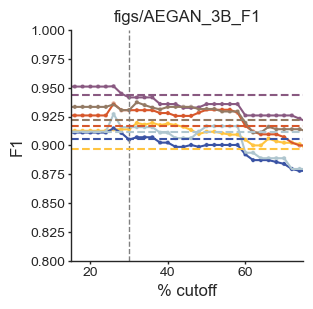

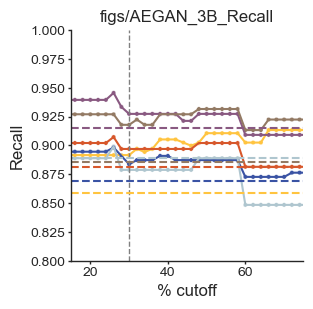

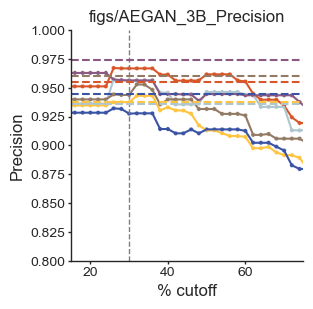

In [81]:
df = pd.DataFrame(rows, columns=['model', 'Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support'])
df_3B = df[df['model'] == '3B']
make_figure(df_3B, x='% cutoff', y='F1', hue='Dataset', filename='figs/AEGAN_3B_F1.svg', model='3B')
make_figure(df_3B, x='% cutoff', y='Recall', hue='Dataset', filename='figs/AEGAN_3B_Recall.svg', model='3B')
make_figure(df_3B, x='% cutoff', y='Precision', hue='Dataset', filename='figs/AEGAN_3B_Precision.svg', model='3B')

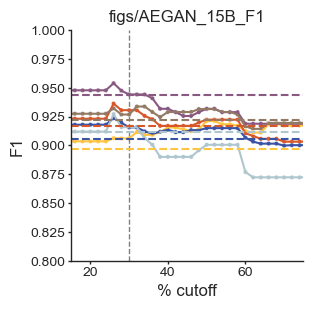

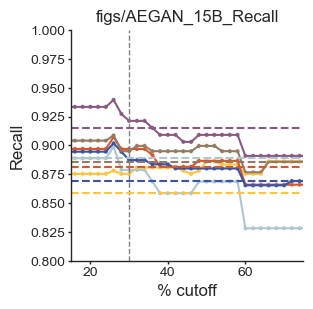

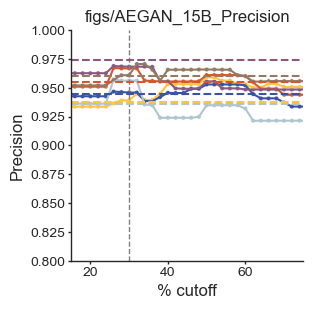

In [82]:
df = pd.DataFrame(rows, columns=['model', 'Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support'])
df_3B = df[df['model'] == '15B']
make_figure(df_3B, x='% cutoff', y='F1', hue='Dataset', filename='figs/AEGAN_15B_F1.svg', model='15B')
make_figure(df_3B, x='% cutoff', y='Recall', hue='Dataset', filename='figs/AEGAN_15B_Recall.svg', model='15B')
make_figure(df_3B, x='% cutoff', y='Precision', hue='Dataset', filename='figs/AEGAN_15B_Precision.svg', model='15B')